## VISUALIZING MODELS, DATA, AND TRAINING WITH TENSORBOARD
https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from d2l.data.fashion_mnist import load_data_fashion_mnist
import torchvision
from IPython import display
import torch

In [2]:
# get the lables of the images
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

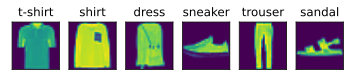

In [3]:
# show the images
def show_fashion_mnist(images, labels):
    display.set_matplotlib_formats('svg')
    # Here _ means that we ignore (not use) variables
    _, figs = plt.subplots(1, len(images), figsize=(6, 6))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.reshape((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

batch_size = 6
train_iter, test_iter = load_data_fashion_mnist(batch_size)

# get some random training images
dataiter = iter(train_iter)
images, labels = dataiter.next()
show_fashion_mnist(images, get_fashion_mnist_labels(labels))

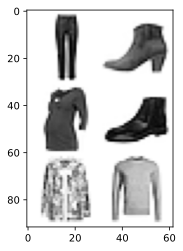

In [4]:
# Another way to plot figures from DataLoader
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = dataiter.next()    # size: (B, H, W)
images = torch.unsqueeze(images, 1) # size: (B, C, H, W)
grid_img = torchvision.utils.make_grid(images, nrow=2) # size: around (C, H*B/nrow, W*nrow)
matplotlib_imshow(grid_img, one_channel=True)

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## TensorBoard Setup & Writing to TensorBoard

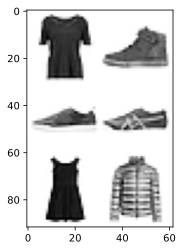

In [6]:
from torch.utils.tensorboard import SummaryWriter

# SummaryWriter: our key object for writing information to TensorBoard.
# default `log_dir` is "runs" - we'll be more specific here
# Note that this line alone creates a runs/fashion_mnist_experiment folder.
writer = SummaryWriter('runs/fashion_mnist_experiment')

# write an image to the TensorBoard
for images, labels in train_iter:
    break
# images, labels = dataiter.next()    # size: (B, H, W)
images = torch.unsqueeze(images, 1) # size: (B, C, H, W)

grid_img = torchvision.utils.make_grid(images, nrow=2) # size: around (C, H*B/nrow, W*nrow)
matplotlib_imshow(grid_img, one_channel=True)

# write to tensorboard
writer.add_image('fashion_mnist_images', grid_img)

# add_graph(model, input_to_model=None, verbose=False)
writer.add_graph(net, images)
writer.close()

### Add Data Projector to TensorBoard

In [7]:
total_num = 100
images, labels = None, None
for X, y in train_iter:
    if images is None:
        images, labels = X, y
    else:
        images = torch.cat((images, X), dim=0)
        labels = torch.cat((labels, y), dim=0)
    if labels.size()[0] >= total_num:
        break
features = images.view(-1, 28 * 28)

writer.add_embedding(features, 
                     metadata=get_fashion_mnist_labels(labels),
                     label_img=images.unsqueeze(1))
writer.close()

In [ ]:
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.2.1 at http://localhost:6006/ (Press CTRL+C to quit)


### Track model training with TensorBoard

In [8]:
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title(f"{get_fashion_mnist_labels([preds[idx]])[0]},"
                     f"{probs[idx] * 100.0:.1f}%\n"
                     f"(label: {get_fashion_mnist_labels([labels[idx]])[0]})", 
                     color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

### writing training loss to TensorBoard every 1000 batches by `add_scalar` 

In [9]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times
    for i, data in enumerate(train_iter):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = torch.unsqueeze(inputs, 1)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...
            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(train_iter) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(train_iter) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


### Assessing trained models with TensorBoard

In [12]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_preds = []
with torch.no_grad():
    for images, labels in test_iter:
        images = torch.unsqueeze(images, 1)
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(get_fashion_mnist_labels([class_index])[0],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(10):
    add_pr_curve_tensorboard(i, test_probs, test_preds)